# AITA Seed Dataset Preparation

Refined workflow for transforming compiled model responses into a balanced seed set ready for human labeling.


## Notebook Overview
- configure environment and reusable constants
- clean the compiled dataset while preserving scenario identifiers
- audit distributional properties with summary tables and charts
- draw a balanced stratified sample across models and scenarios
- format the sample for JSONL seed export


## 1. Environment Setup
Configure imports, display options, and file system paths.


In [225]:
# Standard library imports
from __future__ import annotations
from collections import defaultdict, deque
from pathlib import Path
from typing import Deque, Dict, Iterable, List, Tuple

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap

In [226]:
pd.options.display.max_colwidth = 120
pd.options.display.max_columns = 20

sns.set_theme(style="whitegrid", context="talk")


def find_project_root(markers: tuple[str, ...] = ("pyproject.toml", "poetry.lock", ".git")) -> Path:
    """Ascend from CWD until a repository marker is located."""
    start = Path.cwd().resolve()
    for directory in (start, *start.parents):
        if any((directory / marker).exists() for marker in markers):
            return directory
    return start


PROJECT_ROOT = find_project_root()
NOTEBOOK_ROOT = Path.cwd().resolve()
DATA_PATH = PROJECT_ROOT / "data/humanLabel/raw/aita_compiled_llm_outputs.csv"
SEED_OUTPUT_PATH = PROJECT_ROOT / "data/humanLabel/seeds/aita_seed.jsonl"
SEED_OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

EXPECTED_COLUMNS: tuple[str, ...] = (
    "scenario_number",
    "scenario_text",
    "reddit_is_asshole",
    "model_name",
    "model_response",
    "model_is_asshole",
)
EXPORT_COLUMNS: tuple[str, ...] = EXPECTED_COLUMNS


### Parameters
Centralised configuration makes it easier to reuse this notebook for future AITA sampling runs.


In [227]:
SAMPLE_SIZE = 300
RANDOM_STATE = 42

## 2. Data Ingestion & Cleaning
Load the compiled outputs, harmonise verdict labels, and rebuild scenario identifiers to remove gaps/duplicates.


In [228]:



def load_dataset(path: Path, expected: Iterable[str]) -> pd.DataFrame:
    """Read CSV, validate schema, and align column ordering."""
    frame = pd.read_csv(path)
    missing = [column for column in expected if column not in frame.columns]
    if missing:
        raise ValueError(f"Missing expected columns: {missing}")

    ordered = list(expected) + [col for col in frame.columns if col not in expected]
    print(f"Loaded {len(frame):,} rows across {len(frame.columns)} columns")
    return frame[ordered]


def rebuild_scenario_numbers(frame: pd.DataFrame) -> pd.DataFrame:
    """Trim scenario text, drop blanks, dedupe per (scenario, model), and reindex scenarios."""
    cleaned = frame.dropna(subset=["scenario_text"]).copy()
    cleaned["scenario_text"] = cleaned["scenario_text"].astype(str).str.strip()

    before = len(cleaned)
    cleaned = cleaned[cleaned["scenario_text"] != ""]
    if len(cleaned) != before:
        print(f"Removed {before - len(cleaned)} rows with empty scenario_text")

    unique_texts = cleaned["scenario_text"].drop_duplicates()
    scenario_lookup = {text: idx for idx, text in enumerate(unique_texts, start=1)}
    cleaned["scenario_number"] = cleaned["scenario_text"].map(scenario_lookup).astype(int)

    duplicate_mask = cleaned.duplicated(subset=["scenario_number", "model_name"], keep="first")
    duplicates = int(duplicate_mask.sum())
    if duplicates:
        cleaned = cleaned.loc[~duplicate_mask].copy()
        print(f"Removed {duplicates} duplicate model responses per scenario")

    return cleaned


def normalize_model_verdicts(frame: pd.DataFrame, column: str = "model_is_asshole") -> pd.DataFrame:
    """Normalize model verdict labels to canonical tokens and drop invalid entries."""
    # Extract first 3 characters, strip whitespace, and convert to uppercase
    first_three_chars = (
        frame[column]
        .astype(str)
        .str.strip()
        .str[:3]
        .str.upper()
    )
    
    # Map to valid labels if they match YTA or NTA
    normalized = first_three_chars.where(
        first_three_chars.isin(['YTA', 'NTA']), 
        None
    )
    
    valid_mask = normalized.notna()
    dropped = len(frame) - int(valid_mask.sum())
    if dropped:
        print(f"Dropped {dropped} rows with invalid {column} labels")

    cleaned = frame.loc[valid_mask].copy()
    cleaned[column] = normalized[valid_mask]
    return cleaned


def normalize_reddit_verdicts(frame: pd.DataFrame, column: str = "reddit_is_asshole") -> pd.DataFrame:
    """Map reddit verdict markers onto canonical labels."""
    # Convert to string, strip whitespace, and map 0/1 to NTA/YTA
    normalized = (
        frame[column]
        .astype(str)
        .str.strip()
        .map({'0': 'NTA', '1': 'YTA'})
    )
    
    valid_mask = normalized.notna()
    dropped = len(frame) - int(valid_mask.sum())
    if dropped:
        print(f"Dropped {dropped} rows with unmapped {column} values")

    cleaned = frame.loc[valid_mask].copy()
    cleaned[column] = normalized[valid_mask]
    return cleaned


def preprocess_dataset(path: Path) -> pd.DataFrame:
    """Full preprocessing pipeline returning a schema-aligned dataframe."""
    frame = load_dataset(path, EXPECTED_COLUMNS)
    frame = rebuild_scenario_numbers(frame)
    frame = normalize_model_verdicts(frame, "model_is_asshole")
    frame = normalize_reddit_verdicts(frame, "reddit_is_asshole")
    frame = frame[list(EXPORT_COLUMNS)].copy()
    print(
        f"Preprocessed to {len(frame):,} rows across {frame['scenario_number'].nunique()} scenarios"
    )
    return frame


In [229]:
clean_df = preprocess_dataset(DATA_PATH)
clean_df.head()


Loaded 6,400 rows across 6 columns
Removed 2 duplicate model responses per scenario
Dropped 40 rows with invalid model_is_asshole labels
Preprocessed to 6,358 rows across 800 scenarios


,scenario_number,scenario_text,reddit_is_asshole,model_name,model_response,model_is_asshole
0,1,"WIBTA if I told my stepdad to clean my room Basically my stepmom got a dog, the dog chewed up some papers in my room...",NTA,Llama-8B,"The age-old debate: Would I Be The Asshole (WIBTA) in this situation?\n\nIn this case, I think you're not the asshol...",NTA
1,2,"Am I The Asshole for Not Wanting to Take My Friend's Fall Pictures with his Girlfriend? So my friend, we'll call Joh...",YTA,Llama-8B,You're not the asshole in this situation. It's completely understandable that you wouldn't want to take pictures of ...,NTA
2,3,"AITA for cutting off a friend for making me uncomfortable? So I had this friend that I knew since elementary school,...",NTA,Llama-8B,You are not the asshole (NTA) for cutting off your friend due to his persistent and unwanted comments about your pla...,NTA
3,4,"AITA for wanting to be paid for emotional labor? Obligatory throwaway account for obvious reasons. And sorry, mobile...",YTA,Llama-8B,"I'm happy to help you vent about this situation!\n\nFirstly, let me say that you're not an asshole for expecting pay...",NTA
4,5,"AITA? I love to give people attention for no reason and then move on. I’ve always been a pretty touchy person, nothi...",YTA,Llama-8B,The eternal conundrum of the attention-seeker!\n\nWhile it's understandable that you enjoy giving attention and affe...,YTA


## 3. Structural Summary
Balanced sampling only works when the underlying distribution is well understood. The summary below highlights dataset breadth and agreement rates.


In [230]:
def summarize_dataset(frame: pd.DataFrame) -> None:
    """Display core counts and an agreement matrix."""
    summary = {
        "rows": len(frame),
        "unique_scenarios": frame['scenario_number'].nunique(),
        "models": frame['model_name'].nunique(),
    }
    alignment = frame['reddit_is_asshole'] == frame['model_is_asshole']
    aligned = alignment.sum()
    misaligned = (~alignment).sum()
    total = aligned + misaligned
    summary['agreement_rate'] = aligned / total if total else float('nan')

    summary_series = pd.Series(summary)
    summary_df = summary_series.to_frame(name='value')
    # Format only the agreement_rate row as percentage
    formatted_df = summary_df.copy()
    if 'agreement_rate' in formatted_df.index:
        formatted_df.loc['agreement_rate', 'value'] = f"{summary['agreement_rate']:.2%}"
    display(formatted_df)

    print('Model verdict distribution:')
    display(frame['model_is_asshole'].value_counts().to_frame('count'))
    print('Reddit verdict distribution:')
    display(frame['reddit_is_asshole'].value_counts().to_frame('count'))

    crosstab = pd.crosstab(frame['reddit_is_asshole'], frame['model_is_asshole'])
    print('Reddit vs Model verdicts:')
    
    # Create a clearer formatted table
    crosstab_formatted = crosstab.copy()
    crosstab_formatted.index.name = 'Reddit Verdict'
    crosstab_formatted.columns.name = 'Model Verdict'
    
    # Add totals and percentages
    crosstab_with_totals = crosstab_formatted.copy()
    crosstab_with_totals['Total'] = crosstab_with_totals.sum(axis=1)
    crosstab_with_totals.loc['Total'] = crosstab_with_totals.sum(axis=0)
    
    print('\nCounts:')
    display(crosstab_with_totals)
    
    # Calculate percentages
    crosstab_pct = crosstab_formatted.div(crosstab_formatted.sum(axis=1), axis=0) * 100
    crosstab_pct = crosstab_pct.round(1)
    crosstab_pct.index.name = 'Reddit Verdict'
    crosstab_pct.columns.name = 'Model Verdict (%)'
    
    print('\nPercentages (row-wise):')
    display(crosstab_pct)
    
    # Agreement analysis
    agreement_count = crosstab_formatted.loc['NTA', 'NTA'] + crosstab_formatted.loc['YTA', 'YTA']
    total_count = crosstab_formatted.sum().sum()
    agreement_rate = (agreement_count / total_count) * 100
    
    print(f'\nAgreement Analysis:')
    print(f'• Total responses: {total_count:,}')
    print(f'• Agreeing responses: {agreement_count:,}')
    print(f'• Agreement rate: {agreement_rate:.1f}%')


summarize_dataset(clean_df)


/var/folders/mh/77mvrnws2zj_yccs8qx8s_sh0000gn/T/ipykernel_30304/194542905.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '64.80%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted_df.loc['agreement_rate', 'value'] = f"{summary['agreement_rate']:.2%}"


,value
rows,6358.0
unique_scenarios,800.0
models,8.0
agreement_rate,64.80%


Model verdict distribution:


,count
model_is_asshole,
NTA,3940
YTA,2418


Reddit verdict distribution:


,count
reddit_is_asshole,
NTA,3358
YTA,3000


Reddit vs Model verdicts:

Counts:


Model Verdict,NTA,YTA,Total
Reddit Verdict,,,
NTA,2530,828,3358
YTA,1410,1590,3000
Total,3940,2418,6358



Percentages (row-wise):


Model Verdict (%),NTA,YTA
Reddit Verdict,,
NTA,75.3,24.7
YTA,47.0,53.0



Agreement Analysis:
• Total responses: 6,358
• Agreeing responses: 4,120
• Agreement rate: 64.8%


## 4. Visual Diagnostics
High-level plots to inspect coverage across models, scenarios, and verdict alignment.


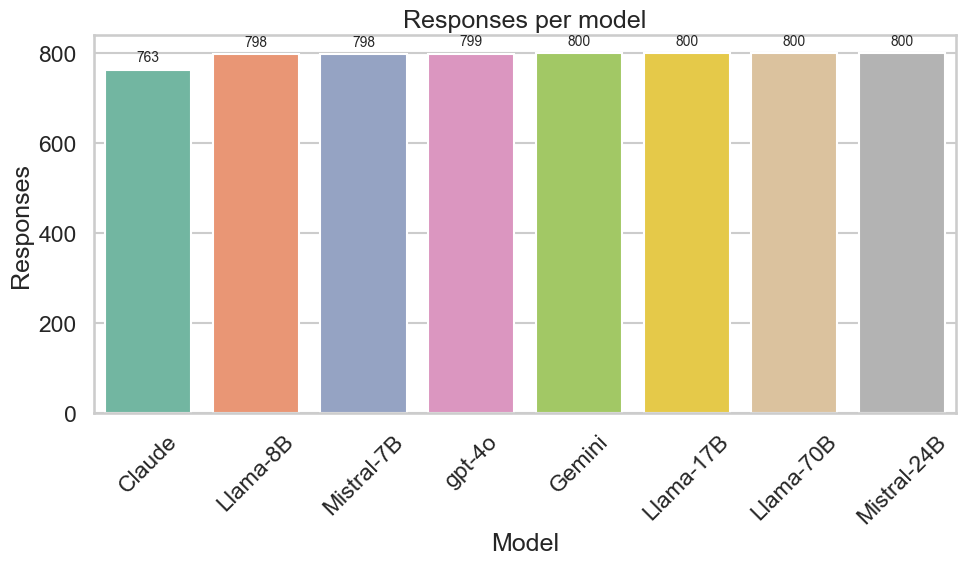

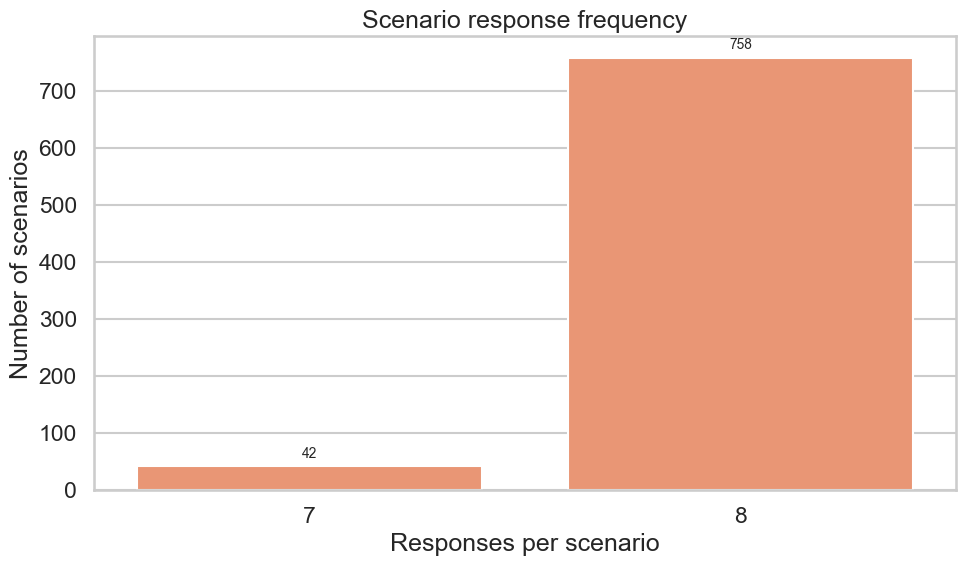

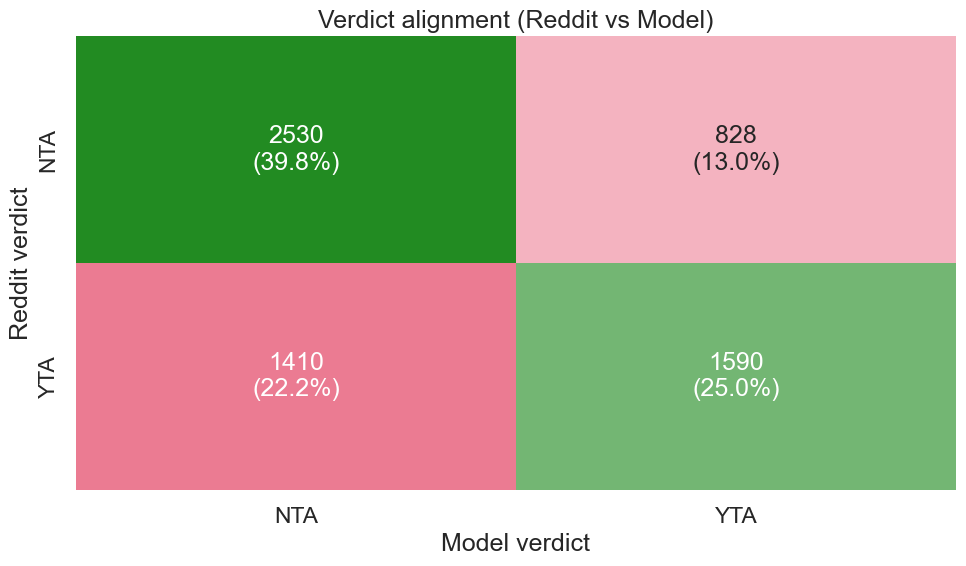

In [231]:
PALETTE = sns.color_palette('Set2')


def plot_model_response_volume(frame: pd.DataFrame, ax: plt.Axes | None = None) -> plt.Axes:
    counts = frame['model_name'].value_counts().sort_values()  
    ax = ax or plt.gca()
    sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette=PALETTE, legend=False, ax=ax)
    ax.set_title('Responses per model')
    ax.set_xlabel('Model')
    ax.set_ylabel('Responses')
    ax.tick_params(axis='x', rotation=45)
    for patch, value in zip(ax.patches, counts.values):
        ax.annotate(f'{value}', (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                    ha='center', va='bottom', fontsize=10, xytext=(0, 4), textcoords='offset points')
    return ax


def plot_scenario_response_span(frame: pd.DataFrame, ax: plt.Axes | None = None) -> plt.Axes:
    scenario_counts = frame['scenario_number'].value_counts()
    response_frequency = scenario_counts.value_counts().sort_index()
    ax = ax or plt.gca()
    sns.barplot(x=response_frequency.index, y=response_frequency.values, color=PALETTE[1], ax=ax)
    ax.set_title('Scenario response frequency')
    ax.set_xlabel('Responses per scenario')
    ax.set_ylabel('Number of scenarios')
    for patch, value in zip(ax.patches, response_frequency.values):
        ax.annotate(f'{value}', (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                    ha='center', va='bottom', fontsize=10, xytext=(0, 4), textcoords='offset points')
    return ax


def plot_alignment_heatmap(frame: pd.DataFrame, ax: plt.Axes | None = None) -> plt.Axes:
    crosstab = pd.crosstab(frame['reddit_is_asshole'], frame['model_is_asshole'])
    ax = ax or plt.gca()
    
    # Calculate percentages for annotations
    total = crosstab.sum().sum()
    crosstab_pct = (crosstab / total * 100).round(1)
    
    # Create annotations with both counts and percentages
    annotations = []
    for i in range(len(crosstab)):
        row_annotations = []
        for j in range(len(crosstab.columns)):
            count = crosstab.iloc[i, j]
            pct = crosstab_pct.iloc[i, j]
            row_annotations.append(f'{count}\n({pct}%)')
        annotations.append(row_annotations)
    
    # Create a proper diverging colormap: red for disagreement, green for agreement
    from matplotlib.colors import LinearSegmentedColormap
    
    # Create a custom diverging colormap: red -> white -> green
    colors = ['#DC143C', '#FFFFFF', '#228B22']  # Crimson red -> White -> Forest green
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('red_white_green', colors, N=n_bins)
    
    # Create a matrix where:
    # - Positive values = agreement (will be green)
    # - Negative values = disagreement (will be red)
    # - Magnitude = count intensity
    agreement_matrix = np.zeros_like(crosstab, dtype=float)
    
    for i in range(len(crosstab)):
        for j in range(len(crosstab.columns)):
            count = crosstab.iloc[i, j]
            if i == j:  # Diagonal = agreement (positive)
                agreement_matrix[i, j] = count
            else:  # Off-diagonal = disagreement (negative)
                agreement_matrix[i, j] = -count
    
    # Plot the heatmap with the diverging colormap
    sns.heatmap(agreement_matrix, annot=annotations, fmt='', cmap=cmap, 
                center=0, cbar=False, ax=ax, 
                vmin=-crosstab.max().max(), vmax=crosstab.max().max(),
                xticklabels=crosstab.columns, yticklabels=crosstab.index)
    ax.set_title('Verdict alignment (Reddit vs Model)')
    ax.set_xlabel('Model verdict')
    ax.set_ylabel('Reddit verdict')
    return ax


# Create 3 separate plots instead of subplots
plt.figure(figsize=(10, 6))
plot_model_response_volume(clean_df)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plot_scenario_response_span(clean_df)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plot_alignment_heatmap(clean_df)
plt.tight_layout()
plt.show()


## 5. Stratified Sampling
Sample responses while maintaining balanced quotas across models and scenarios.


In [232]:
def _build_quota(items: List[int | str], total: int) -> Dict[int | str, int]:
    base, remainder = divmod(total, len(items))
    quota = {item: base for item in items}
    for idx in range(remainder):
        quota[items[idx]] += 1
    return quota


def _prepare_model_scenarios(frame: pd.DataFrame, models: List[str], random_state: int) -> Dict[str, Deque[int]]:
    lookup: Dict[str, Deque[int]] = {}
    for offset, model in enumerate(models):
        scenarios = (
            frame.loc[frame['model_name'] == model, 'scenario_number']
            .drop_duplicates()
            .sample(frac=1.0, random_state=random_state + offset)
            .tolist()
        )
        lookup[model] = deque(int(val) for val in scenarios)
    return lookup


def _index_rows_by_model_and_scenario(frame: pd.DataFrame) -> Dict[Tuple[str, int], List[int]]:
    index: Dict[Tuple[str, int], List[int]] = defaultdict(list)
    for idx, row in frame.iterrows():
        index[(row['model_name'], int(row['scenario_number']))].append(idx)
    return index


def sample_balanced_models_and_scenarios_dual_quota(
    frame: pd.DataFrame,
    total_n: int,
    random_state: int,
) -> pd.DataFrame:
    """Select rows balancing quotas across model_name and scenario_number."""
    if total_n <= 0:
        raise ValueError('total_n must be positive')

    models = sorted(frame['model_name'].unique())
    scenarios = sorted(frame['scenario_number'].unique())
    if not models or not scenarios:
        return frame.iloc[0:0].copy()

    model_quota = _build_quota(models, total_n)
    scenario_quota = _build_quota(scenarios, total_n)
    model_to_scenarios = _prepare_model_scenarios(frame, models, random_state)
    row_lookup = _index_rows_by_model_and_scenario(frame)

    picked_indices: List[int] = []
    model_idx = 0

    def select_scenario(model: str, enforce_quota: bool) -> int | None:
        queue = model_to_scenarios[model]
        if not queue:
            return None
        for _ in range(len(queue)):
            candidate = queue[0]
            queue.rotate(-1)
            if (model, candidate) not in row_lookup:
                continue
            if not enforce_quota or scenario_quota.get(candidate, 0) > 0:
                return candidate
        return None

    while len(picked_indices) < total_n and any(val > 0 for val in model_quota.values()):
        model = models[model_idx % len(models)]
        model_idx += 1
        if model_quota[model] <= 0:
            continue

        chosen = select_scenario(model, enforce_quota=True)
        if chosen is None:
            chosen = select_scenario(model, enforce_quota=False)
            if chosen is None:
                model_quota[model] = 0
                continue

        pool = row_lookup[(model, chosen)]
        position = (model_quota[model] + scenario_quota.get(chosen, 0) + random_state) % len(pool)
        picked_indices.append(pool[position])

        model_quota[model] -= 1
        if scenario_quota.get(chosen, 0) > 0:
            scenario_quota[chosen] -= 1

    return frame.loc[picked_indices].reset_index(drop=True)


In [233]:
sample_df = sample_balanced_models_and_scenarios_dual_quota(
    clean_df,
    total_n=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
)

print(f'Sample size: {len(sample_df)}')
print('Model counts:')
display(sample_df['model_name'].value_counts().sort_index().to_frame('count'))
scenario_counts = sample_df['scenario_number'].value_counts()
print('Scenario coverage:')
print(f"min {scenario_counts.min()} | max {scenario_counts.max()}")
print(f"unique scenarios: {len(scenario_counts)} of {clean_df['scenario_number'].nunique()}")


Sample size: 300
Model counts:


,count
model_name,
Claude,38
Gemini,38
Llama-17B,38
Llama-70B,38
Llama-8B,37
Mistral-24B,37
Mistral-7B,37
gpt-4o,37


Scenario coverage:
min 1 | max 1
unique scenarios: 300 of 800


## 6. Seed Formatting
Convert the sampled rows into the JSONL schema expected by the labeling pipeline.


In [234]:
DEFAULT_SOURCE = 'reddit-aita'
DEFAULT_VERSION = '2025-01'
DEFAULT_TOPIC = 'general'
SEED_RUN_ID = 'aita-balanced-v1'

VALID_LABELS = {'YTA', 'NTA'}
NEUTRAL_LABEL = 'UNKNOWN'
REDDIT_YTA_MARKERS = {'1', 'TRUE', 'YTA'}
REDDIT_NTA_MARKERS = {'0', 'FALSE', 'NTA'}


def normalize_label(value: object) -> str:
    label = str(value).strip().upper()
    return label if label in VALID_LABELS else NEUTRAL_LABEL


def normalize_reddit_label(value: object) -> str:
    marker = str(value).strip().upper()
    if marker in REDDIT_YTA_MARKERS:
        return 'YTA'
    if marker in REDDIT_NTA_MARKERS:
        return 'NTA'
    return NEUTRAL_LABEL


def slugify_model(model_name: str) -> str:
    safe = str(model_name).lower()
    for ch in ' /\\:':
        safe = safe.replace(ch, '-')
    safe = ''.join(ch for ch in safe if ch.isalnum() or ch == '-')
    return safe.strip('-') or 'model'


def build_prompt_title(row: pd.Series) -> str:
    reddit_label = normalize_reddit_label(row.get('reddit_is_asshole'))
    model_label = normalize_label(row.get('model_is_asshole'))
    return f'R: {reddit_label} AI: {model_label}'


def build_identifier(row: pd.Series) -> str:
    scenario_id = int(row['scenario_number'])
    model_slug = slugify_model(row.get('model_name', 'model'))
    return f'aita_{scenario_id:03d}_{model_slug}'


def build_metadata(_: pd.Series) -> Dict[str, str]:
    return {
        'source': DEFAULT_SOURCE,
        'version': DEFAULT_VERSION,
        'topic': DEFAULT_TOPIC,
    }


def prepare_seed_export(frame: pd.DataFrame) -> pd.DataFrame:
    required_cols = {
        'scenario_number',
        'scenario_text',
        'model_response',
        'model_name',
        'model_is_asshole',
        'reddit_is_asshole',
    }
    missing = required_cols - set(frame.columns)
    if missing:
        raise KeyError(f'Missing columns for seed export: {missing}')

    export_frame = frame.copy()
    export_frame['identifier'] = export_frame.apply(build_identifier, axis=1)
    export_frame['prompt_title'] = export_frame.apply(build_prompt_title, axis=1)
    export_frame['prompt_body'] = export_frame['scenario_text'].astype(str).str.strip()
    export_frame['model_response_text'] = export_frame['model_response'].astype(str)
    export_frame['model_id'] = export_frame['model_name'].astype(str)
    export_frame['run_id'] = SEED_RUN_ID
    export_frame['metadata'] = export_frame.apply(build_metadata, axis=1)

    ordered = export_frame.sort_values(['scenario_number', 'model_name']).reset_index(drop=True)
    columns = [
        'identifier',
        'prompt_title',
        'prompt_body',
        'model_response_text',
        'model_id',
        'run_id',
        'metadata',
    ]
    return ordered[columns]


seed_export_df = prepare_seed_export(sample_df)
display(seed_export_df.head())


,identifier,prompt_title,prompt_body,model_response_text,model_id,run_id,metadata
0,aita_001_llama-70b,R: NTA AI: NTA,"WIBTA if I told my stepdad to clean my room Basically my stepmom got a dog, the dog chewed up some papers in my room...","You're wondering if you would be in the wrong (WIBTA) for telling your stepdad to clean your room, given the circums...",Llama-70B,aita-balanced-v1,"{'source': 'reddit-aita', 'version': '2025-01', 'topic': 'general'}"
1,aita_002_mistral-7b,R: YTA AI: NTA,"Am I The Asshole for Not Wanting to Take My Friend's Fall Pictures with his Girlfriend? So my friend, we'll call Joh...","Based on the information you've provided, it's understandable that you don't want to take pictures of your friend an...",Mistral-7B,aita-balanced-v1,"{'source': 'reddit-aita', 'version': '2025-01', 'topic': 'general'}"
2,aita_003_mistral-7b,R: NTA AI: NTA,"AITA for cutting off a friend for making me uncomfortable? So I had this friend that I knew since elementary school,...","Based on the information provided, it seems like you have a right to feel uncomfortable and set boundaries in your f...",Mistral-7B,aita-balanced-v1,"{'source': 'reddit-aita', 'version': '2025-01', 'topic': 'general'}"
3,aita_004_llama-17b,R: YTA AI: NTA,"AITA for wanting to be paid for emotional labor? Obligatory throwaway account for obvious reasons. And sorry, mobile...","NTA (Not The Asshole). You provided a significant service to your family, putting your life on hold for a week to ca...",Llama-17B,aita-balanced-v1,"{'source': 'reddit-aita', 'version': '2025-01', 'topic': 'general'}"
4,aita_005_llama-70b,R: YTA AI: YTA,"AITA? I love to give people attention for no reason and then move on. I’ve always been a pretty touchy person, nothi...",You're Not The Asshole (NTA) in the sense that you're not intentionally trying to hurt or manipulate others. However...,Llama-70B,aita-balanced-v1,"{'source': 'reddit-aita', 'version': '2025-01', 'topic': 'general'}"


## 7. Export
Persist the seed sample as JSONL for downstream labeling workflows.


In [235]:
seed_export_df.to_json(SEED_OUTPUT_PATH, orient='records', lines=True, force_ascii=False)
print(f'Saved {len(seed_export_df)} rows')


Saved 300 rows
